# `HFSLTEModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `HFSLTEModel` model. The `HFSLTEModel` models the hyperfine spectral structure of an arbitrary molecule in order to predict the physical conditions of the emitting gas. Furthermore, we assume local thermodynamic equilibrium (LTE), such that the excitation temperature of every transition is equal to the kinetic temperature of the cloud. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+1.gc22da00.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])

# molecular weight (number of protons)
weight_12CN = 12.0 + 14.0

dict_keys(['freq', 'Aul', 'degu', 'Eu', 'relative_int', 'log10_Q_terms'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]


## Simulating Data

To test the model, we must simulate some data. We can do this with `HFSLTEModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"observation"`.

1000


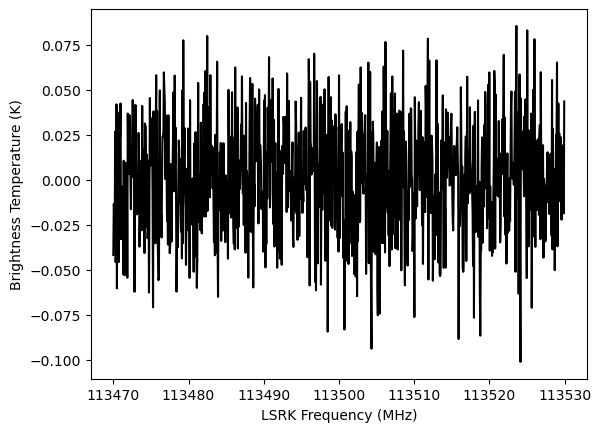

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.06) # MHz
# freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz
print(len(freq_axis))

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

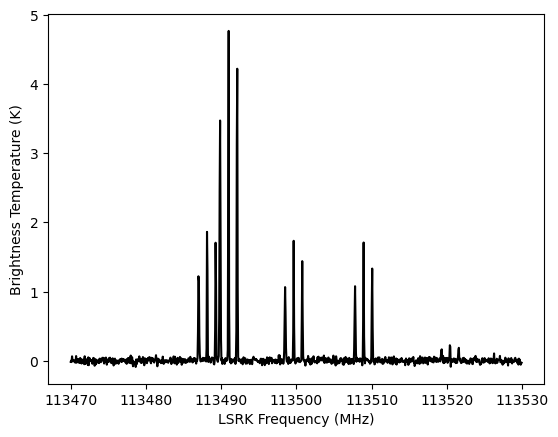

In [4]:
from bayes_cn_hfs import HFSLTEModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = HFSLTEModel(
    dummy_data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "tau_total": [1.0, 2.0, 0.5],
    "log10_Tkin": [1.5, 1.25, 1.75],
    "velocity": [-3.0, 0.0, 3.0],
    "baseline_observation_norm": [0.0],
    "fwhm_L": 0.0,
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `HFSLTEModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = HFSLTEModel(
    data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

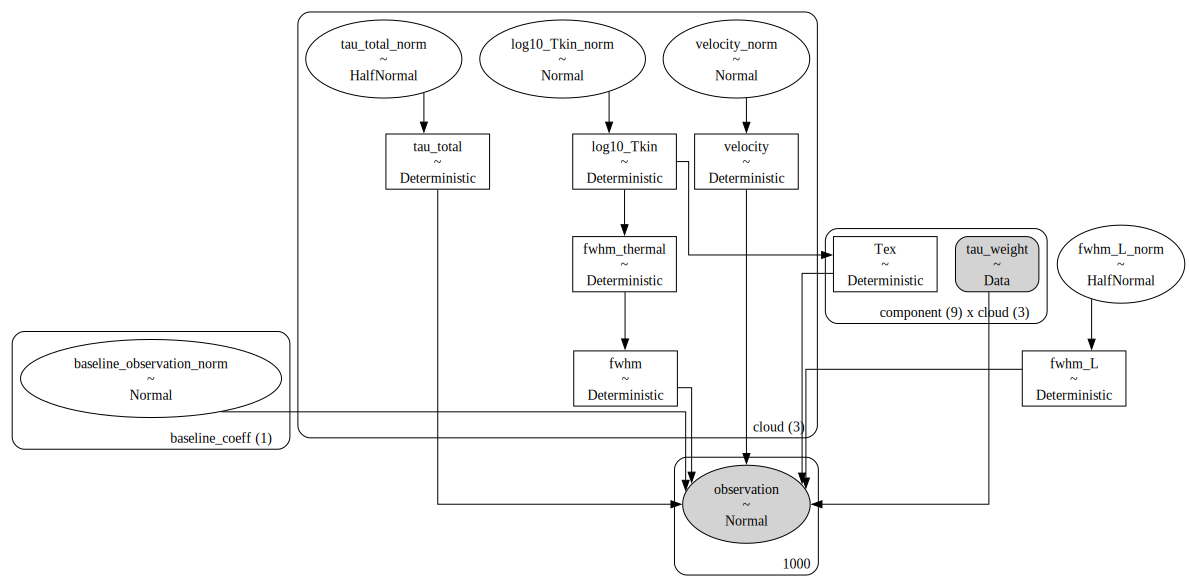

In [7]:
# Plot model graph
model.graph().render('hfs_lte_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, 1)
           tau_total_norm ~ HalfNormal(0, 1)
          log10_Tkin_norm ~ Normal(0, 1)
            velocity_norm ~ Normal(0, 1)
              fwhm_L_norm ~ HalfNormal(0, 1)
                tau_total ~ Deterministic(f(tau_total_norm))
               log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
                 velocity ~ Deterministic(f(velocity_norm))
             fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
                     fwhm ~ Deterministic(f(log10_Tkin_norm))
                   fwhm_L ~ Deterministic(f(fwhm_L_norm))
                      Tex ~ Deterministic(f(log10_Tkin_norm))
              observation ~ Normal(f(baseline_observation_norm, tau_total_norm, log10_Tkin_norm, fwhm_L_norm, velocity_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_observation_norm, fwhm_L_norm, log10_Tkin_norm, observation, tau_total_norm, velocity_norm]


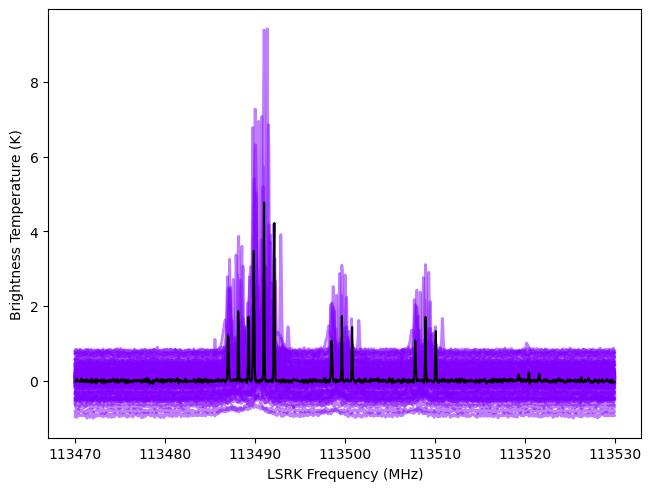

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 31,235


Output()

Runtime: 1.20 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.163,0.003,-0.169,-0.157,0.000,0.000,970.0,936.0,NaN
log10_Tkin_norm[0],-1.239,0.010,-1.258,-1.221,0.000,0.000,963.0,983.0,NaN
log10_Tkin_norm[1],0.129,0.013,0.107,0.155,0.000,0.000,939.0,870.0,NaN
log10_Tkin_norm[2],1.471,0.014,1.444,1.496,0.000,0.000,1156.0,975.0,NaN
velocity_norm[0],0.002,0.001,0.001,0.003,0.000,0.000,845.0,1008.0,NaN
velocity_norm[1],-1.001,0.001,-1.003,-1.000,0.000,0.000,1016.0,975.0,NaN
velocity_norm[2],1.000,0.001,0.999,1.002,0.000,0.000,1020.0,983.0,NaN
tau_total_norm[0],1.995,0.013,1.972,2.018,0.000,0.000,1017.0,866.0,NaN
tau_total_norm[1],0.951,0.006,0.940,0.962,0.000,0.000,1033.0,992.0,NaN
tau_total_norm[2],0.456,0.003,0.451,0.462,0.000,0.000,1037.0,881.0,NaN


Sampling: [observation]


Output()

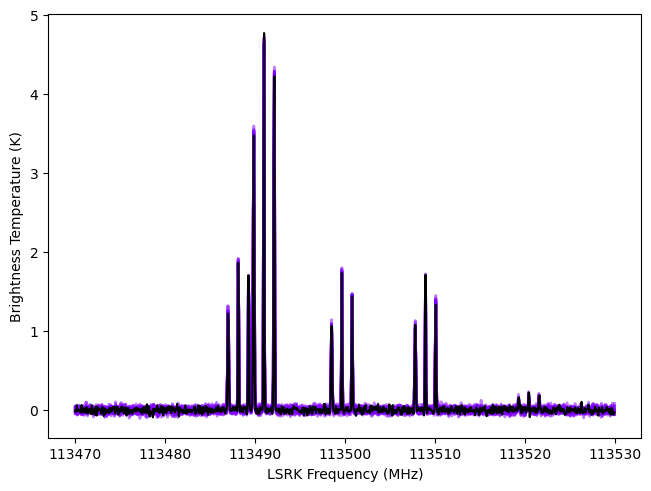

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 31,235
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, tau_total_norm, log10_Tkin_norm, velocity_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 417 seconds.


Adding log-likelihood to trace


Output()

Runtime: 8.52 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.163,0.003,-0.169,-0.157,0.000,0.000,10019.0,5511.0,1.0
log10_Tkin_norm[0],-1.245,0.059,-1.358,-1.137,0.001,0.001,4473.0,4683.0,1.0
log10_Tkin_norm[1],0.119,0.046,0.032,0.206,0.001,0.000,4795.0,4466.0,1.0
log10_Tkin_norm[2],1.465,0.044,1.386,1.551,0.001,0.000,4717.0,4242.0,1.0
velocity_norm[0],0.000,0.000,-0.000,0.001,0.000,0.000,9883.0,5216.0,1.0
velocity_norm[1],-1.000,0.000,-1.000,-0.999,0.000,0.000,10850.0,5641.0,1.0
velocity_norm[2],1.000,0.000,0.999,1.001,0.000,0.000,10271.0,5399.0,1.0
tau_total_norm[0],2.023,0.080,1.880,2.177,0.001,0.001,3936.0,4287.0,1.0
tau_total_norm[1],0.948,0.023,0.902,0.991,0.000,0.000,3924.0,4365.0,1.0
tau_total_norm[2],0.453,0.009,0.436,0.470,0.000,0.000,3768.0,3961.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

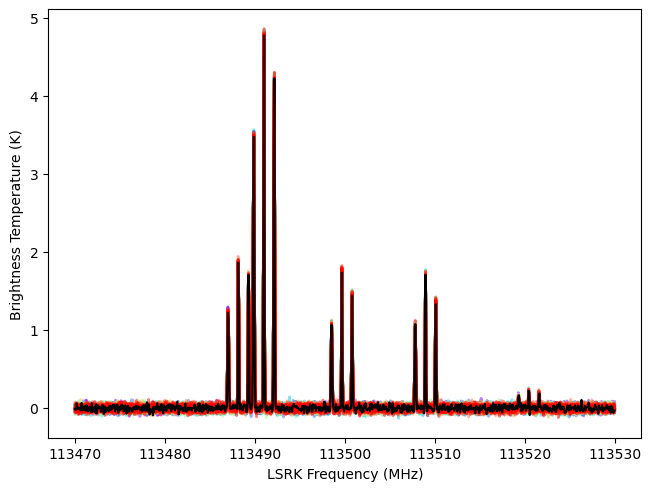

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

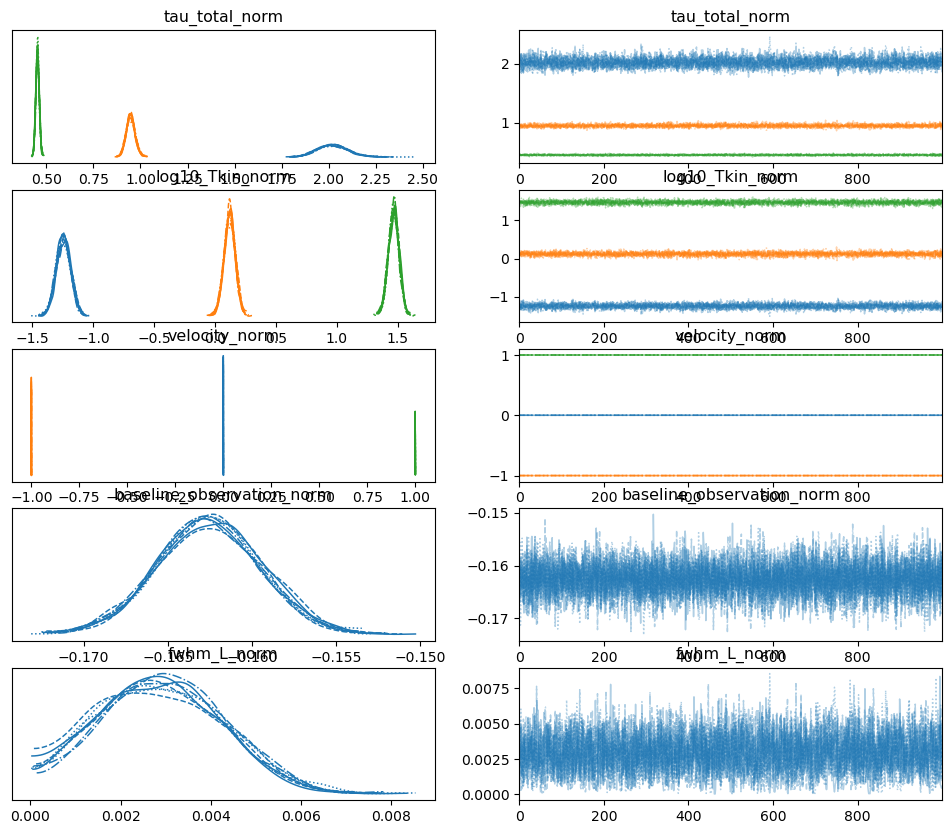

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

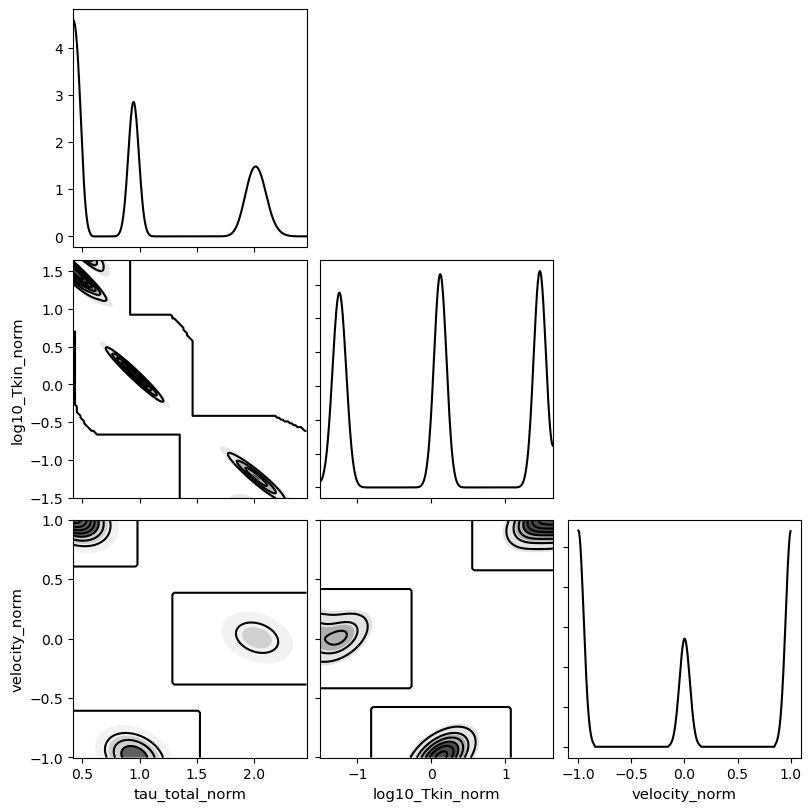

In [25]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition excitation temperatures for clarity) along with the model hyper-parameters.

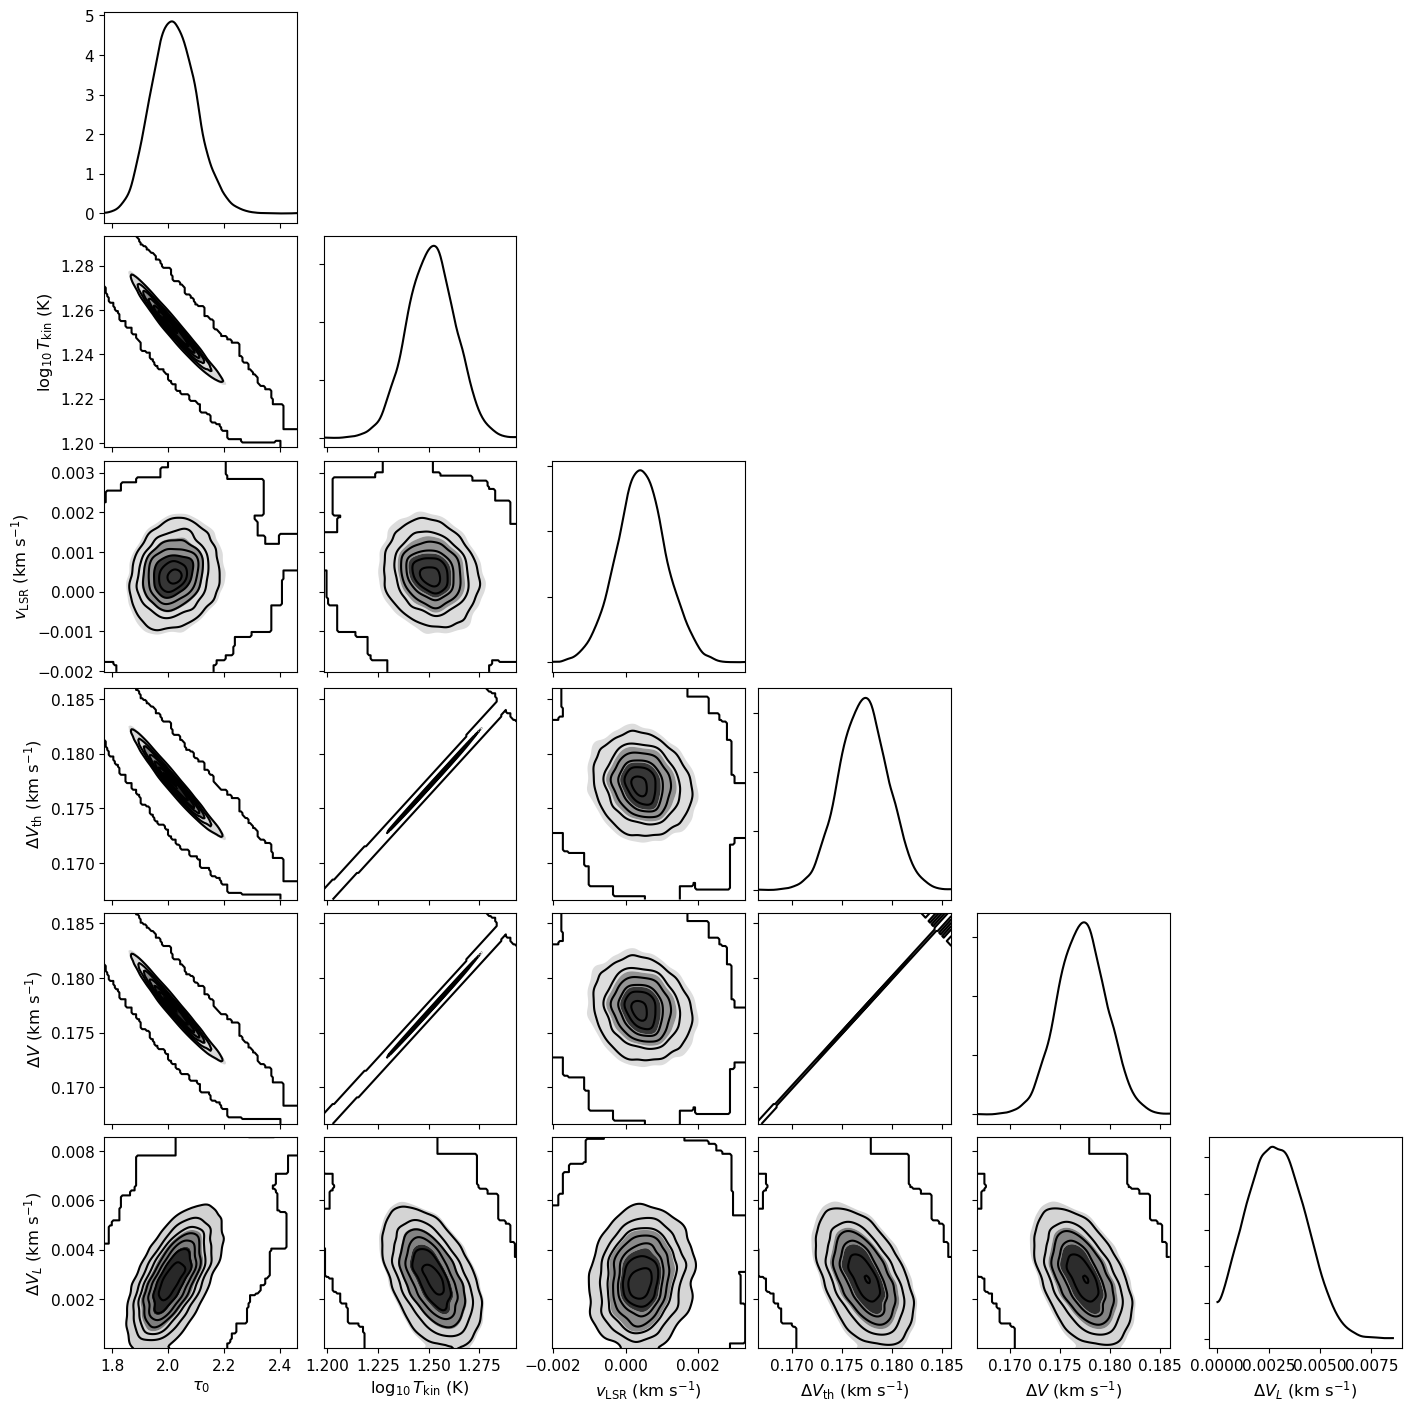

In [27]:
var_names = [param for param in model.cloud_deterministics if "Tex" not in param]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [29]:
var_names=model.cloud_deterministics + model.baseline_deterministics + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -4121.466088063278


,mean,sd,hdi_16%,hdi_84%
tau_total[0],2.023,0.080,1.946,2.103
tau_total[1],0.948,0.023,0.926,0.972
tau_total[2],0.453,0.009,0.443,0.461
log10_Tkin[0],1.251,0.012,1.239,1.263
log10_Tkin[1],1.524,0.009,1.515,1.533
log10_Tkin[2],1.793,0.009,1.784,1.802
velocity[0],0.000,0.001,-0.000,0.001
velocity[1],-3.000,0.001,-3.000,-2.999
velocity[2],3.000,0.001,2.998,3.001
fwhm_thermal[0],0.177,0.002,0.175,0.180


## Model Degeneracies Consideration: Spectral Resolution

The equation of radiative transfer is $T_B = T_{\rm ex} (1 - e^{-\tau})$. Generally speaking, it is difficult to break the degeneracy between excitation temperature and optical depth from the brightness temperature spectrum alone. If we assume LTE and only thermal line broadening, however, then the line width independently constrains the kinetic temperature and thus the excitation temperature (in LTE). In the above demonstration, our synthetic observation had sufficient spectral resolution to constrain the thermal line width and thus break the degeneracy. Now we demonstrate what happens if the spectral resolution is insufficient to resolve the narrow thermal lines.

300


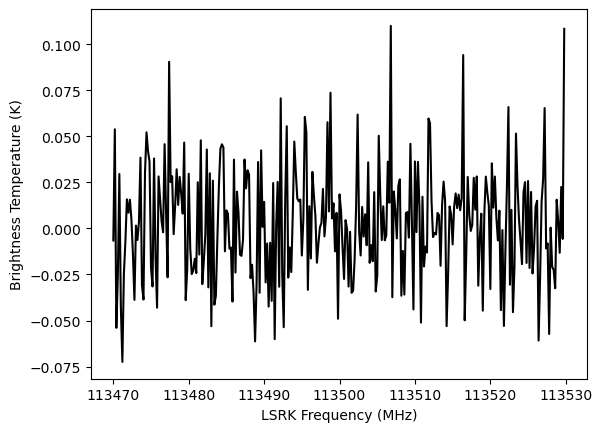

In [30]:
from bayes_spec import SpecData

# spectral axis definition
# freq_axis = np.arange(113470.0, 113530.0, 0.06) # MHz
freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz
print(len(freq_axis))

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

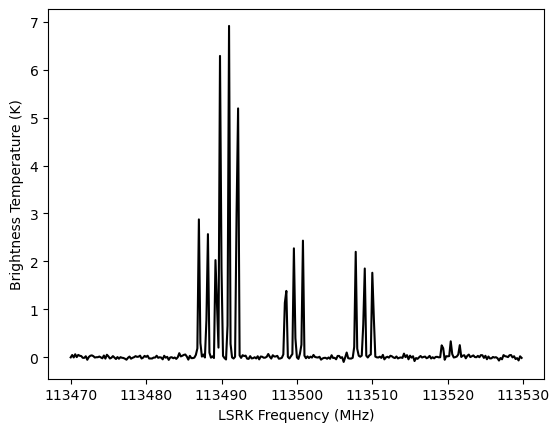

In [31]:
from bayes_cn_hfs import HFSLTEModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = HFSLTEModel(
    dummy_data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "tau_total": [1.0, 2.0, 0.5],
    "log10_Tkin": [1.5, 1.25, 1.75],
    "velocity": [-3.0, 0.0, 3.0],
    "baseline_observation_norm": [0.0],
    "fwhm_L": 0.0,
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [32]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

In [33]:
# Initialize and define the model
model = HFSLTEModel(
    data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

## MCMC

In [37]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 44,887
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, tau_total_norm, log10_Tkin_norm, velocity_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 310 seconds.


Adding log-likelihood to trace


Output()

Runtime: 5.90 minutes


In [41]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [observation]


Output()

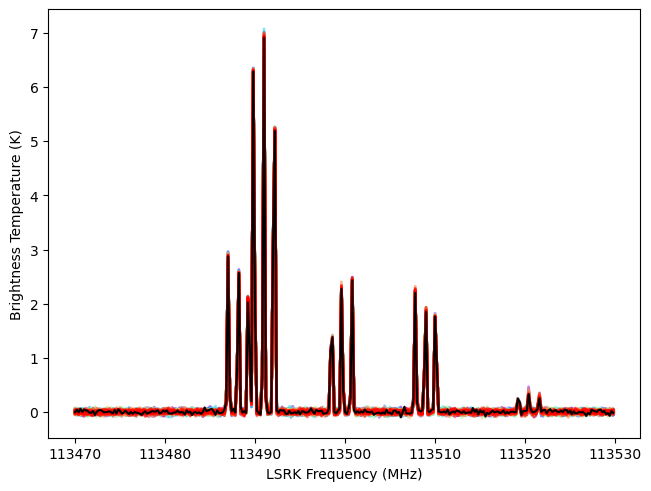

In [42]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

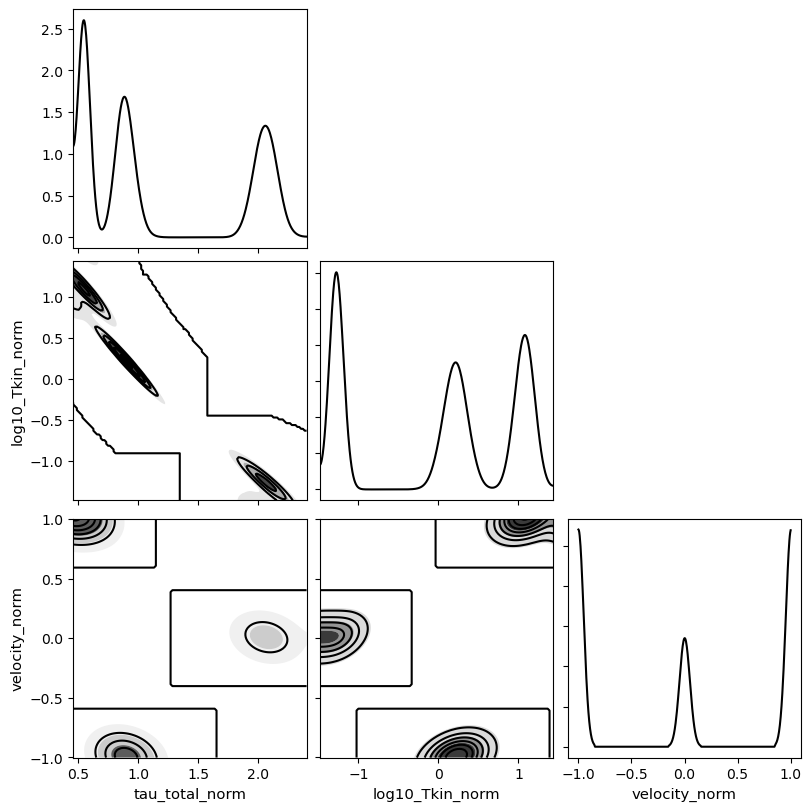

In [43]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice the strong degeneracy between optical depth and kinetic temperature. At this spectral resolution, we can still place reasonable constraints on these parameters, but it's getting more challenging to break that degeneracy.

## Model Degeneracies Consideration: Non-thermal broadening

If there is any non-thermal broadening, then it is impossible to break the degeneracy between excitation temperature and optical depth. Here we demonstrate the problem.

1000


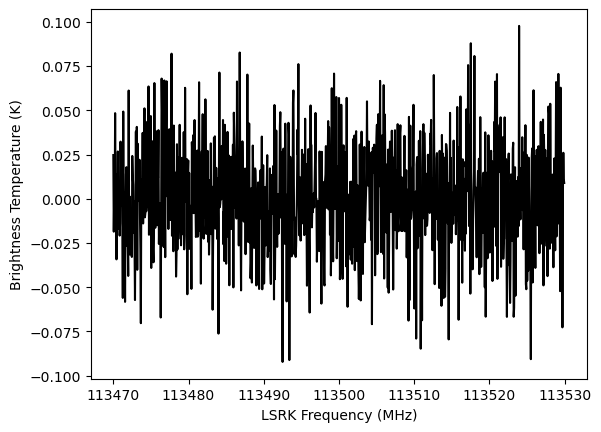

In [44]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.06) # MHz
# freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz
print(len(freq_axis))

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

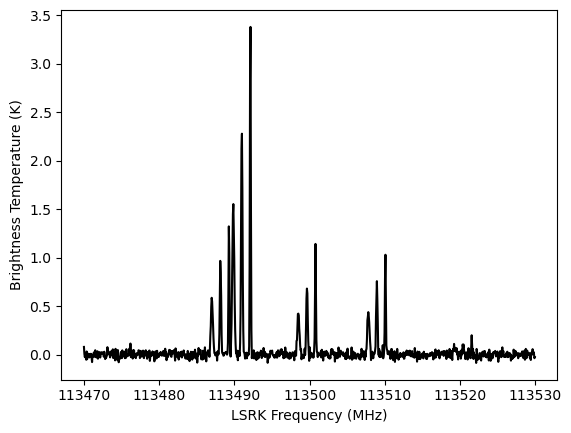

In [45]:
from bayes_cn_hfs import HFSLTEModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = HFSLTEModel(
    dummy_data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "tau_total": [1.0, 2.0, 0.5],
    "log10_Tkin": [1.5, 1.25, 1.75],
    "velocity": [-3.0, 0.0, 3.0],
    "fwhm_nonthermal": [0.25, 0.5, 0.75],
    "baseline_observation_norm": [0.0],
    "fwhm_L": 0.0,
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [46]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

In [47]:
# Initialize and define the model
model = HFSLTEModel(
    data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

## MCMC

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8400
Interrupted at 8,399 [8%]: Average Loss = 9,485.2
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, tau_total_norm, log10_Tkin_norm, velocity_norm, fwhm_L_norm]


Output()